###### Targets:
	- > 99.4+ & also a consistently higher accuracies.
	- There will be no increase in the total params as compared to previous attempts. Total 
	  params in all these attempts has to be under 10K.

###### Results (5th Attempt):
	- max Validation Accuracy reached: ~99.44%
	- max Train Accuracy reached: ~98.86%
	- Total params: 9,736
  
##### Analysis:
	- We observe a more consistent 99.3+% performance, with validation accuracy finally reaching 99.44%
	- The rotation image augmentation in a separate investigation didn't help in this case, hence didn't use it.


# Import Libraries

In [1]:
from __future__ import print_function
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

C:\Users\ojhaj\Anaconda3\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ojhaj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\ojhaj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.txa6yqsd3gcqqc22geq54j2udcxdxhwn.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
class_names  = [ "zero",  # index 0
                 "one",   # index 1
                 "two",   # index 2 
                 "three", # index 3 
                 "four",  # index 4
                 "five",  # index 5
                 "six",   # index 6 
                 "seven", # index 7 
                 "eight", # index 8 
                 "nine"]  # index 9

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train_mnist = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_mnist = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_mnist, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_mnist, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

C:\Users\ojhaj\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


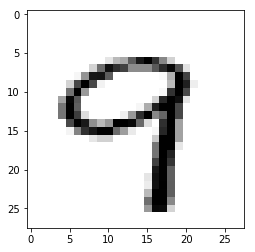

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train_mnist.train_data
train_data = train_mnist.transform(train_data.numpy())
#train_data = train.train_data.cpu().numpy()

print('[Train]')
print(' - Numpy Shape:', train_mnist.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train_mnist.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)


plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

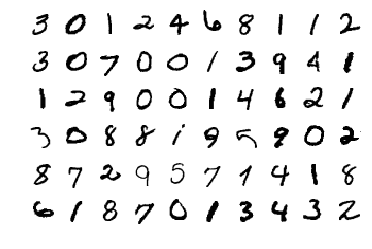

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [7]:
l1_weight = 0.01

In [8]:
dropout_value = 0.1
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [9]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model1 = Net1().to(device)
summary(model1, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def l1_penalty(x):
    return torch.abs(x).sum()

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        to_reg = []
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        for param in model.parameters():
            to_reg.append(param.view(-1))
        l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        
        # Calculate loss
        loss = F.nll_loss(y_pred, target) + l1
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [11]:
model1 =  Net1().to(device)
optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model1, device, train_loader, optimizer, epoch)
    test(model1, device, test_loader)

EPOCH: 0


Loss=1.8129286766052246 Batch_id=937 Accuracy=81.33: 100%|███████████████████████████| 938/938 [00:17<00:00, 52.53it/s]



Test set: Average loss: 1.4291, Accuracy: 6113/10000 (61.13%)

EPOCH: 1


Loss=1.4601246118545532 Batch_id=937 Accuracy=86.95: 100%|███████████████████████████| 938/938 [00:18<00:00, 57.52it/s]



Test set: Average loss: 1.2184, Accuracy: 6372/10000 (63.72%)

EPOCH: 2


Loss=1.7365801334381104 Batch_id=937 Accuracy=86.94: 100%|███████████████████████████| 938/938 [00:17<00:00, 52.60it/s]



Test set: Average loss: 1.0127, Accuracy: 6753/10000 (67.53%)

EPOCH: 3


Loss=1.7212944030761719 Batch_id=937 Accuracy=86.85: 100%|███████████████████████████| 938/938 [00:18<00:00, 50.83it/s]



Test set: Average loss: 1.4905, Accuracy: 5235/10000 (52.35%)

EPOCH: 4


Loss=1.92267644405365 Batch_id=937 Accuracy=86.47: 100%|█████████████████████████████| 938/938 [00:18<00:00, 51.51it/s]



Test set: Average loss: 2.8684, Accuracy: 3975/10000 (39.75%)

EPOCH: 5


Loss=1.2376630306243896 Batch_id=937 Accuracy=86.52: 100%|███████████████████████████| 938/938 [00:18<00:00, 51.91it/s]



Test set: Average loss: 0.6553, Accuracy: 8039/10000 (80.39%)

EPOCH: 6


Loss=1.6673316955566406 Batch_id=937 Accuracy=86.65: 100%|███████████████████████████| 938/938 [00:17<00:00, 59.48it/s]



Test set: Average loss: 0.8820, Accuracy: 7169/10000 (71.69%)

EPOCH: 7


Loss=1.428556203842163 Batch_id=937 Accuracy=86.28: 100%|████████████████████████████| 938/938 [00:18<00:00, 51.40it/s]



Test set: Average loss: 1.2522, Accuracy: 5982/10000 (59.82%)

EPOCH: 8


Loss=1.3762223720550537 Batch_id=937 Accuracy=86.23: 100%|███████████████████████████| 938/938 [00:18<00:00, 51.42it/s]



Test set: Average loss: 0.6126, Accuracy: 7984/10000 (79.84%)

EPOCH: 9


Loss=1.3344279527664185 Batch_id=937 Accuracy=86.39: 100%|███████████████████████████| 938/938 [00:18<00:00, 58.35it/s]



Test set: Average loss: 2.0890, Accuracy: 4771/10000 (47.71%)

EPOCH: 10


Loss=1.5213768482208252 Batch_id=937 Accuracy=86.06: 100%|███████████████████████████| 938/938 [00:18<00:00, 57.39it/s]



Test set: Average loss: 0.6587, Accuracy: 8001/10000 (80.01%)

EPOCH: 11


Loss=1.691284418106079 Batch_id=937 Accuracy=86.19: 100%|████████████████████████████| 938/938 [00:18<00:00, 51.81it/s]



Test set: Average loss: 0.7920, Accuracy: 7521/10000 (75.21%)

EPOCH: 12


Loss=1.339398741722107 Batch_id=937 Accuracy=86.46: 100%|████████████████████████████| 938/938 [00:18<00:00, 50.79it/s]



Test set: Average loss: 1.0637, Accuracy: 7045/10000 (70.45%)

EPOCH: 13


Loss=1.7610300779342651 Batch_id=937 Accuracy=86.39: 100%|███████████████████████████| 938/938 [00:18<00:00, 50.15it/s]



Test set: Average loss: 0.5521, Accuracy: 8272/10000 (82.72%)

EPOCH: 14


Loss=1.8510557413101196 Batch_id=937 Accuracy=86.36: 100%|███████████████████████████| 938/938 [00:18<00:00, 50.69it/s]



Test set: Average loss: 1.1063, Accuracy: 7066/10000 (70.66%)

EPOCH: 15


Loss=1.3562612533569336 Batch_id=937 Accuracy=86.41: 100%|███████████████████████████| 938/938 [00:18<00:00, 50.73it/s]



Test set: Average loss: 0.9525, Accuracy: 7027/10000 (70.27%)

EPOCH: 16


Loss=1.2266833782196045 Batch_id=937 Accuracy=86.81: 100%|███████████████████████████| 938/938 [00:18<00:00, 50.87it/s]



Test set: Average loss: 0.6859, Accuracy: 7886/10000 (78.86%)

EPOCH: 17


Loss=1.5971274375915527 Batch_id=937 Accuracy=86.54: 100%|███████████████████████████| 938/938 [00:18<00:00, 50.82it/s]



Test set: Average loss: 0.8636, Accuracy: 7373/10000 (73.73%)

EPOCH: 18


Loss=1.4846512079238892 Batch_id=937 Accuracy=86.53: 100%|███████████████████████████| 938/938 [00:18<00:00, 50.64it/s]



Test set: Average loss: 1.1176, Accuracy: 6473/10000 (64.73%)

EPOCH: 19


Loss=1.3453056812286377 Batch_id=937 Accuracy=86.25: 100%|███████████████████████████| 938/938 [00:18<00:00, 51.25it/s]



Test set: Average loss: 1.0535, Accuracy: 6759/10000 (67.59%)



Text(0.5, 1.0, 'Test Accuracy')

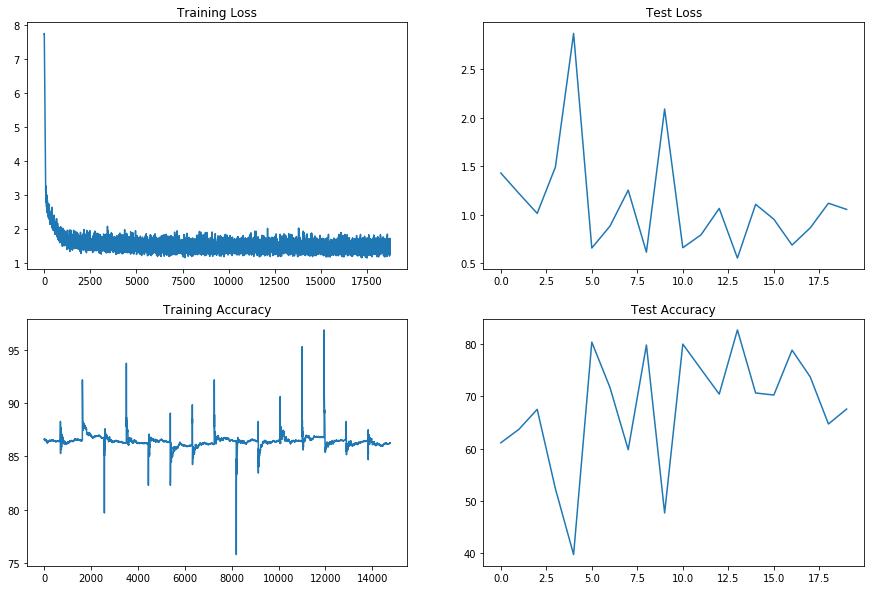

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [7]:
l1_weight = 0.001

In [8]:
dropout_value = 0.1
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [9]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model2 = Net2().to(device)
summary(model2, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def l1_penalty(x):
    return torch.abs(x).sum()

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        to_reg = []
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        for param in model.parameters():
            to_reg.append(param.view(-1))
        l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        
        # Calculate loss
        loss = F.nll_loss(y_pred, target) + l1
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [12]:
model2 =  Net2().to(device)
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model2, device, train_loader, optimizer, epoch)
    test(model2, device, test_loader)

EPOCH: 0


Loss=0.4477294087409973 Batch_id=937 Accuracy=87.09: 100%|███████████████████████████| 938/938 [00:17<00:00, 52.36it/s]



Test set: Average loss: 0.1080, Accuracy: 9707/10000 (97.07%)

EPOCH: 1


Loss=0.7234359979629517 Batch_id=937 Accuracy=96.14: 100%|███████████████████████████| 938/938 [00:18<00:00, 51.84it/s]



Test set: Average loss: 0.0784, Accuracy: 9777/10000 (97.77%)

EPOCH: 2


Loss=0.6326354742050171 Batch_id=937 Accuracy=96.46: 100%|███████████████████████████| 938/938 [00:17<00:00, 52.20it/s]



Test set: Average loss: 0.1604, Accuracy: 9505/10000 (95.05%)

EPOCH: 3


Loss=0.35536617040634155 Batch_id=937 Accuracy=96.66: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.63it/s]



Test set: Average loss: 0.0712, Accuracy: 9802/10000 (98.02%)

EPOCH: 4


Loss=0.40446898341178894 Batch_id=937 Accuracy=96.63: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.93it/s]



Test set: Average loss: 0.0935, Accuracy: 9743/10000 (97.43%)

EPOCH: 5


Loss=0.36491185426712036 Batch_id=937 Accuracy=96.64: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.18it/s]



Test set: Average loss: 0.1137, Accuracy: 9629/10000 (96.29%)

EPOCH: 6


Loss=0.41434353590011597 Batch_id=937 Accuracy=96.67: 100%|██████████████████████████| 938/938 [00:18<00:00, 57.51it/s]



Test set: Average loss: 0.0661, Accuracy: 9810/10000 (98.10%)

EPOCH: 7


Loss=0.4716945290565491 Batch_id=937 Accuracy=96.55: 100%|███████████████████████████| 938/938 [00:18<00:00, 50.46it/s]



Test set: Average loss: 0.0925, Accuracy: 9722/10000 (97.22%)

EPOCH: 8


Loss=0.5329471826553345 Batch_id=937 Accuracy=96.71: 100%|███████████████████████████| 938/938 [00:18<00:00, 51.18it/s]



Test set: Average loss: 0.0678, Accuracy: 9805/10000 (98.05%)

EPOCH: 9


Loss=0.3954463303089142 Batch_id=937 Accuracy=96.53: 100%|███████████████████████████| 938/938 [00:18<00:00, 51.53it/s]



Test set: Average loss: 0.0842, Accuracy: 9743/10000 (97.43%)

EPOCH: 10


Loss=0.36950331926345825 Batch_id=937 Accuracy=96.53: 100%|██████████████████████████| 938/938 [00:18<00:00, 59.78it/s]



Test set: Average loss: 0.0693, Accuracy: 9798/10000 (97.98%)

EPOCH: 11


Loss=0.3623918890953064 Batch_id=937 Accuracy=96.66: 100%|███████████████████████████| 938/938 [00:17<00:00, 58.87it/s]



Test set: Average loss: 0.0884, Accuracy: 9700/10000 (97.00%)

EPOCH: 12


Loss=0.5098081827163696 Batch_id=937 Accuracy=96.53: 100%|███████████████████████████| 938/938 [00:18<00:00, 56.59it/s]



Test set: Average loss: 0.0711, Accuracy: 9801/10000 (98.01%)

EPOCH: 13


Loss=0.435339093208313 Batch_id=937 Accuracy=96.66: 100%|████████████████████████████| 938/938 [00:18<00:00, 57.94it/s]



Test set: Average loss: 0.0888, Accuracy: 9718/10000 (97.18%)

EPOCH: 14


Loss=0.37685534358024597 Batch_id=937 Accuracy=96.65: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.56it/s]



Test set: Average loss: 0.1122, Accuracy: 9655/10000 (96.55%)

EPOCH: 15


Loss=0.31157657504081726 Batch_id=937 Accuracy=96.63: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.12it/s]



Test set: Average loss: 0.1010, Accuracy: 9715/10000 (97.15%)

EPOCH: 16


Loss=0.31561416387557983 Batch_id=937 Accuracy=96.74: 100%|██████████████████████████| 938/938 [00:18<00:00, 57.89it/s]



Test set: Average loss: 0.0714, Accuracy: 9778/10000 (97.78%)

EPOCH: 17


Loss=0.28662270307540894 Batch_id=937 Accuracy=96.58: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.99it/s]



Test set: Average loss: 0.0914, Accuracy: 9713/10000 (97.13%)

EPOCH: 18


Loss=0.35181939601898193 Batch_id=937 Accuracy=96.59: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.60it/s]



Test set: Average loss: 0.0813, Accuracy: 9760/10000 (97.60%)

EPOCH: 19


Loss=0.31511321663856506 Batch_id=937 Accuracy=96.52: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.17it/s]



Test set: Average loss: 0.0560, Accuracy: 9843/10000 (98.43%)



Text(0.5, 1.0, 'Test Accuracy')

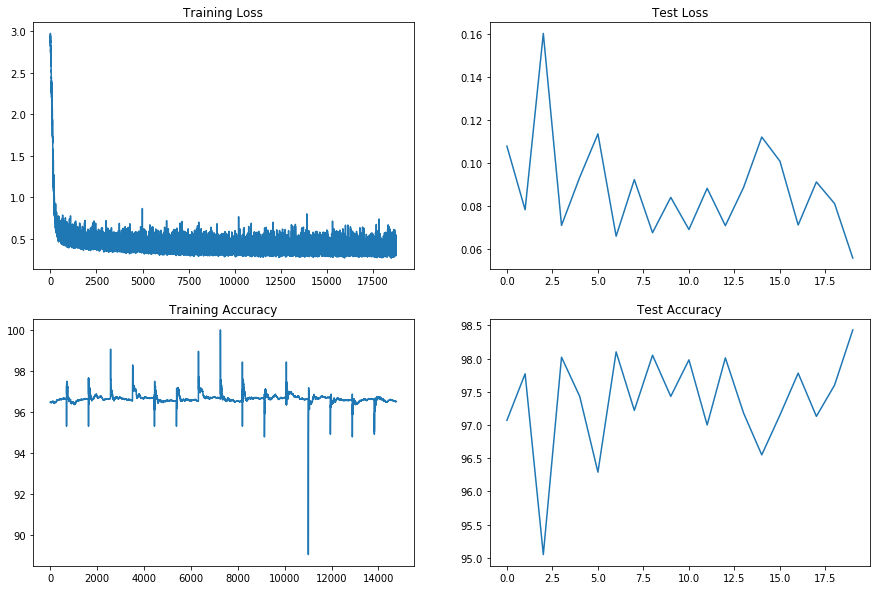

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [7]:
l1_weight = 0.0001

In [8]:
dropout_value = 0.1
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [9]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model3 = Net3().to(device)
summary(model3, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def l1_penalty(x):
    return torch.abs(x).sum()

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        to_reg = []
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        for param in model.parameters():
            to_reg.append(param.view(-1))
        l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        
        # Calculate loss
        loss = F.nll_loss(y_pred, target) + l1
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
model3 =  Net3().to(device)
optimizer = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model3, device, train_loader, optimizer, epoch)
    test(model3, device, test_loader)

EPOCH: 0


Loss=0.282250314950943 Batch_id=937 Accuracy=87.39: 100%|████████████████████████████| 938/938 [00:17<00:00, 53.02it/s]



Test set: Average loss: 0.0629, Accuracy: 9835/10000 (98.35%)

EPOCH: 1


Loss=0.09762513637542725 Batch_id=937 Accuracy=97.36: 100%|██████████████████████████| 938/938 [00:17<00:00, 59.13it/s]



Test set: Average loss: 0.0457, Accuracy: 9862/10000 (98.62%)

EPOCH: 2


Loss=0.23638643324375153 Batch_id=937 Accuracy=97.88: 100%|██████████████████████████| 938/938 [00:17<00:00, 51.00it/s]



Test set: Average loss: 0.0339, Accuracy: 9891/10000 (98.91%)

EPOCH: 3


Loss=0.09767375141382217 Batch_id=937 Accuracy=98.03: 100%|██████████████████████████| 938/938 [00:16<00:00, 56.05it/s]



Test set: Average loss: 0.0410, Accuracy: 9856/10000 (98.56%)

EPOCH: 4


Loss=0.11116573959589005 Batch_id=937 Accuracy=98.16: 100%|██████████████████████████| 938/938 [00:17<00:00, 59.08it/s]



Test set: Average loss: 0.0311, Accuracy: 9906/10000 (99.06%)

EPOCH: 5


Loss=0.07002146542072296 Batch_id=937 Accuracy=98.28: 100%|██████████████████████████| 938/938 [00:19<00:00, 54.93it/s]



Test set: Average loss: 0.0308, Accuracy: 9910/10000 (99.10%)

EPOCH: 6


Loss=0.30988648533821106 Batch_id=937 Accuracy=98.38: 100%|██████████████████████████| 938/938 [00:17<00:00, 63.60it/s]



Test set: Average loss: 0.0264, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.21596263349056244 Batch_id=937 Accuracy=98.38: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.96it/s]



Test set: Average loss: 0.0268, Accuracy: 9915/10000 (99.15%)

EPOCH: 8


Loss=0.06715211272239685 Batch_id=937 Accuracy=98.39: 100%|██████████████████████████| 938/938 [00:17<00:00, 54.66it/s]



Test set: Average loss: 0.0274, Accuracy: 9922/10000 (99.22%)

EPOCH: 9


Loss=0.07154727727174759 Batch_id=937 Accuracy=98.42: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.15it/s]



Test set: Average loss: 0.0265, Accuracy: 9911/10000 (99.11%)

EPOCH: 10


Loss=0.09933606535196304 Batch_id=937 Accuracy=98.44: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.08it/s]



Test set: Average loss: 0.0251, Accuracy: 9918/10000 (99.18%)

EPOCH: 11


Loss=0.22557446360588074 Batch_id=937 Accuracy=98.60: 100%|██████████████████████████| 938/938 [00:16<00:00, 56.24it/s]



Test set: Average loss: 0.0289, Accuracy: 9905/10000 (99.05%)

EPOCH: 12


Loss=0.07832186669111252 Batch_id=937 Accuracy=98.47: 100%|██████████████████████████| 938/938 [00:19<00:00, 47.98it/s]



Test set: Average loss: 0.0246, Accuracy: 9925/10000 (99.25%)

EPOCH: 13


Loss=0.1222497969865799 Batch_id=937 Accuracy=98.54: 100%|███████████████████████████| 938/938 [00:18<00:00, 57.62it/s]



Test set: Average loss: 0.0234, Accuracy: 9928/10000 (99.28%)

EPOCH: 14


Loss=0.24104252457618713 Batch_id=937 Accuracy=98.64: 100%|██████████████████████████| 938/938 [00:18<00:00, 58.64it/s]



Test set: Average loss: 0.0218, Accuracy: 9939/10000 (99.39%)

EPOCH: 15


Loss=0.15051884949207306 Batch_id=937 Accuracy=98.61: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.19it/s]



Test set: Average loss: 0.0333, Accuracy: 9892/10000 (98.92%)

EPOCH: 16


Loss=0.06464239209890366 Batch_id=937 Accuracy=98.56: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.34it/s]



Test set: Average loss: 0.0278, Accuracy: 9908/10000 (99.08%)

EPOCH: 17


Loss=0.27529963850975037 Batch_id=937 Accuracy=98.62: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.12it/s]



Test set: Average loss: 0.0231, Accuracy: 9922/10000 (99.22%)

EPOCH: 18


Loss=0.07105297595262527 Batch_id=937 Accuracy=98.57: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.80it/s]



Test set: Average loss: 0.0240, Accuracy: 9926/10000 (99.26%)

EPOCH: 19


Loss=0.08207625895738602 Batch_id=937 Accuracy=98.61: 100%|██████████████████████████| 938/938 [00:18<00:00, 57.89it/s]



Test set: Average loss: 0.0252, Accuracy: 9912/10000 (99.12%)



Text(0.5, 1.0, 'Test Accuracy')

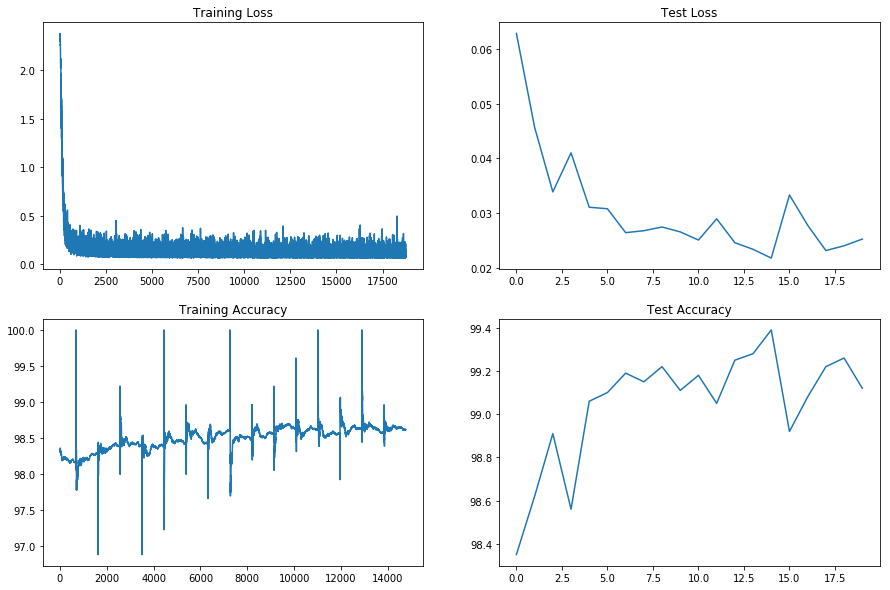

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [7]:
l1_weight = 0.00001

In [8]:
dropout_value = 0.1
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [9]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model4 = Net4().to(device)
summary(model4, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def l1_penalty(x):
    return torch.abs(x).sum()

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        to_reg = []
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        for param in model.parameters():
            to_reg.append(param.view(-1))
        l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        
        # Calculate loss
        loss = F.nll_loss(y_pred, target) + l1
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
model4 =  Net4().to(device)
optimizer = optim.SGD(model4.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model4, device, train_loader, optimizer, epoch)
    test(model4, device, test_loader)

EPOCH: 0


Loss=0.1989631950855255 Batch_id=937 Accuracy=87.33: 100%|███████████████████████████| 938/938 [00:18<00:00, 51.42it/s]



Test set: Average loss: 0.0556, Accuracy: 9848/10000 (98.48%)

EPOCH: 1


Loss=0.024681346490979195 Batch_id=937 Accuracy=97.40: 100%|█████████████████████████| 938/938 [00:18<00:00, 51.01it/s]



Test set: Average loss: 0.0386, Accuracy: 9887/10000 (98.87%)

EPOCH: 2


Loss=0.19051653146743774 Batch_id=937 Accuracy=97.89: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.12it/s]



Test set: Average loss: 0.0332, Accuracy: 9895/10000 (98.95%)

EPOCH: 3


Loss=0.0182346124202013 Batch_id=937 Accuracy=98.11: 100%|███████████████████████████| 938/938 [00:19<00:00, 48.00it/s]



Test set: Average loss: 0.0298, Accuracy: 9911/10000 (99.11%)

EPOCH: 4


Loss=0.10215052962303162 Batch_id=937 Accuracy=98.36: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.60it/s]



Test set: Average loss: 0.0282, Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.013369577936828136 Batch_id=937 Accuracy=98.37: 100%|█████████████████████████| 938/938 [00:18<00:00, 51.22it/s]



Test set: Average loss: 0.0257, Accuracy: 9930/10000 (99.30%)

EPOCH: 6


Loss=0.19873516261577606 Batch_id=937 Accuracy=98.55: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.40it/s]



Test set: Average loss: 0.0264, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.10836033523082733 Batch_id=937 Accuracy=98.55: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.77it/s]



Test set: Average loss: 0.0250, Accuracy: 9920/10000 (99.20%)

EPOCH: 8


Loss=0.01326593104749918 Batch_id=937 Accuracy=98.64: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.01it/s]



Test set: Average loss: 0.0216, Accuracy: 9935/10000 (99.35%)

EPOCH: 9


Loss=0.0205253753811121 Batch_id=937 Accuracy=98.62: 100%|███████████████████████████| 938/938 [00:18<00:00, 50.98it/s]



Test set: Average loss: 0.0237, Accuracy: 9929/10000 (99.29%)

EPOCH: 10


Loss=0.034636396914720535 Batch_id=937 Accuracy=98.72: 100%|█████████████████████████| 938/938 [00:18<00:00, 51.98it/s]



Test set: Average loss: 0.0235, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.0969628095626831 Batch_id=937 Accuracy=98.75: 100%|███████████████████████████| 938/938 [00:18<00:00, 51.48it/s]



Test set: Average loss: 0.0233, Accuracy: 9922/10000 (99.22%)

EPOCH: 12


Loss=0.015022019855678082 Batch_id=937 Accuracy=98.79: 100%|█████████████████████████| 938/938 [00:18<00:00, 50.41it/s]



Test set: Average loss: 0.0210, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.0568617545068264 Batch_id=937 Accuracy=98.80: 100%|███████████████████████████| 938/938 [00:17<00:00, 53.07it/s]



Test set: Average loss: 0.0193, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


Loss=0.3260546922683716 Batch_id=937 Accuracy=98.84: 100%|███████████████████████████| 938/938 [00:18<00:00, 50.73it/s]



Test set: Average loss: 0.0201, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.017204681411385536 Batch_id=937 Accuracy=98.87: 100%|█████████████████████████| 938/938 [00:18<00:00, 50.80it/s]



Test set: Average loss: 0.0225, Accuracy: 9927/10000 (99.27%)

EPOCH: 16


Loss=0.011021798476576805 Batch_id=937 Accuracy=98.89: 100%|█████████████████████████| 938/938 [00:18<00:00, 56.93it/s]



Test set: Average loss: 0.0206, Accuracy: 9936/10000 (99.36%)

EPOCH: 17


Loss=0.12771807610988617 Batch_id=937 Accuracy=98.90: 100%|██████████████████████████| 938/938 [00:18<00:00, 61.79it/s]



Test set: Average loss: 0.0212, Accuracy: 9932/10000 (99.32%)

EPOCH: 18


Loss=0.02252385765314102 Batch_id=937 Accuracy=98.87: 100%|██████████████████████████| 938/938 [00:16<00:00, 56.37it/s]



Test set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)

EPOCH: 19


Loss=0.04302499443292618 Batch_id=937 Accuracy=98.86: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.09it/s]



Test set: Average loss: 0.0199, Accuracy: 9929/10000 (99.29%)



Text(0.5, 1.0, 'Test Accuracy')

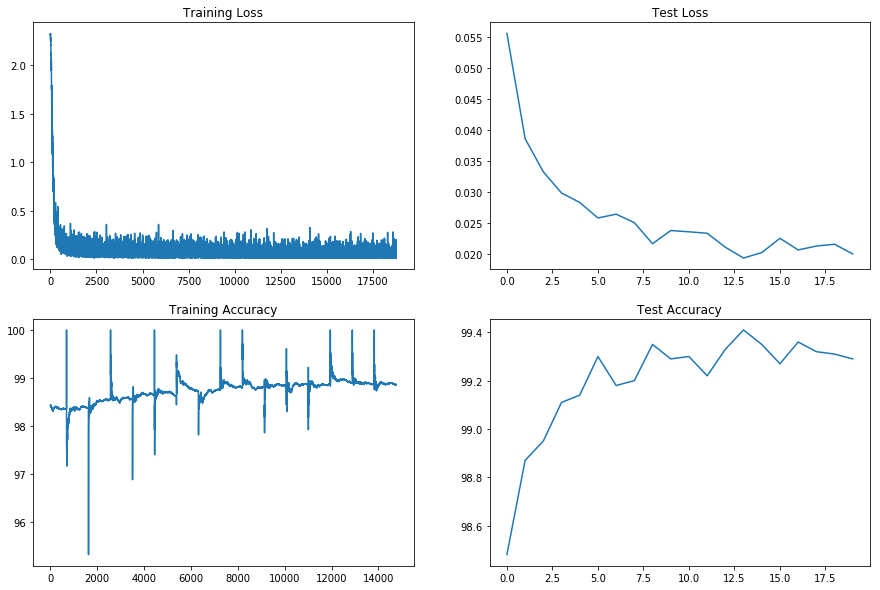

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [7]:
l1_weight = 0.000001 #as if l1 absent

In [8]:
dropout_value = 0.1
class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [9]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model5 = Net5().to(device)
summary(model5, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def l1_penalty(x):
    return torch.abs(x).sum()

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        to_reg = []
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        for param in model.parameters():
            to_reg.append(param.view(-1))
        l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        
        # Calculate loss
        loss = F.nll_loss(y_pred, target) + l1
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
model5 =  Net5().to(device)
optimizer = optim.SGD(model5.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model5, device, train_loader, optimizer, epoch)
    test(model5, device, test_loader)

EPOCH: 0


Loss=0.20339398086071014 Batch_id=937 Accuracy=87.33: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.42it/s]



Test set: Average loss: 0.0547, Accuracy: 9849/10000 (98.49%)

EPOCH: 1


Loss=0.024123022332787514 Batch_id=937 Accuracy=97.38: 100%|█████████████████████████| 938/938 [00:17<00:00, 60.50it/s]



Test set: Average loss: 0.0407, Accuracy: 9879/10000 (98.79%)

EPOCH: 2


Loss=0.17022134363651276 Batch_id=937 Accuracy=97.87: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.06it/s]



Test set: Average loss: 0.0312, Accuracy: 9900/10000 (99.00%)

EPOCH: 3


Loss=0.016774430871009827 Batch_id=937 Accuracy=98.14: 100%|█████████████████████████| 938/938 [00:17<00:00, 52.23it/s]



Test set: Average loss: 0.0306, Accuracy: 9907/10000 (99.07%)

EPOCH: 4


Loss=0.06165248528122902 Batch_id=937 Accuracy=98.32: 100%|██████████████████████████| 938/938 [00:18<00:00, 52.04it/s]



Test set: Average loss: 0.0299, Accuracy: 9906/10000 (99.06%)

EPOCH: 5


Loss=0.006155727431178093 Batch_id=937 Accuracy=98.41: 100%|█████████████████████████| 938/938 [00:18<00:00, 51.78it/s]



Test set: Average loss: 0.0278, Accuracy: 9918/10000 (99.18%)

EPOCH: 6


Loss=0.23644033074378967 Batch_id=937 Accuracy=98.58: 100%|██████████████████████████| 938/938 [00:17<00:00, 58.35it/s]



Test set: Average loss: 0.0251, Accuracy: 9924/10000 (99.24%)

EPOCH: 7


Loss=0.09299503266811371 Batch_id=937 Accuracy=98.53: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.73it/s]



Test set: Average loss: 0.0231, Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.004155246540904045 Batch_id=937 Accuracy=98.66: 100%|█████████████████████████| 938/938 [00:18<00:00, 51.00it/s]



Test set: Average loss: 0.0238, Accuracy: 9930/10000 (99.30%)

EPOCH: 9


Loss=0.008963614702224731 Batch_id=937 Accuracy=98.63: 100%|█████████████████████████| 938/938 [00:17<00:00, 52.71it/s]



Test set: Average loss: 0.0229, Accuracy: 9935/10000 (99.35%)

EPOCH: 10


Loss=0.01106424443423748 Batch_id=937 Accuracy=98.75: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.65it/s]



Test set: Average loss: 0.0245, Accuracy: 9923/10000 (99.23%)

EPOCH: 11


Loss=0.084022156894207 Batch_id=937 Accuracy=98.82: 100%|████████████████████████████| 938/938 [00:18<00:00, 51.57it/s]



Test set: Average loss: 0.0235, Accuracy: 9916/10000 (99.16%)

EPOCH: 12


Loss=0.016700267791748047 Batch_id=937 Accuracy=98.80: 100%|█████████████████████████| 938/938 [00:18<00:00, 51.13it/s]



Test set: Average loss: 0.0222, Accuracy: 9931/10000 (99.31%)

EPOCH: 13


Loss=0.031065400689840317 Batch_id=937 Accuracy=98.85: 100%|█████████████████████████| 938/938 [00:18<00:00, 51.48it/s]



Test set: Average loss: 0.0190, Accuracy: 9942/10000 (99.42%)

EPOCH: 14


Loss=0.16527903079986572 Batch_id=937 Accuracy=98.84: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.86it/s]



Test set: Average loss: 0.0192, Accuracy: 9941/10000 (99.41%)

EPOCH: 15


Loss=0.025645963847637177 Batch_id=937 Accuracy=98.89: 100%|█████████████████████████| 938/938 [00:18<00:00, 51.77it/s]



Test set: Average loss: 0.0227, Accuracy: 9924/10000 (99.24%)

EPOCH: 16


Loss=0.002485918812453747 Batch_id=937 Accuracy=98.85: 100%|█████████████████████████| 938/938 [00:18<00:00, 59.32it/s]



Test set: Average loss: 0.0229, Accuracy: 9930/10000 (99.30%)

EPOCH: 17


Loss=0.10737261176109314 Batch_id=937 Accuracy=98.85: 100%|██████████████████████████| 938/938 [00:18<00:00, 52.00it/s]



Test set: Average loss: 0.0196, Accuracy: 9938/10000 (99.38%)

EPOCH: 18


Loss=0.037270352244377136 Batch_id=937 Accuracy=98.93: 100%|█████████████████████████| 938/938 [00:17<00:00, 52.16it/s]



Test set: Average loss: 0.0211, Accuracy: 9932/10000 (99.32%)

EPOCH: 19


Loss=0.012362063862383366 Batch_id=937 Accuracy=98.91: 100%|█████████████████████████| 938/938 [00:18<00:00, 50.53it/s]



Test set: Average loss: 0.0212, Accuracy: 9929/10000 (99.29%)



Text(0.5, 1.0, 'Test Accuracy')

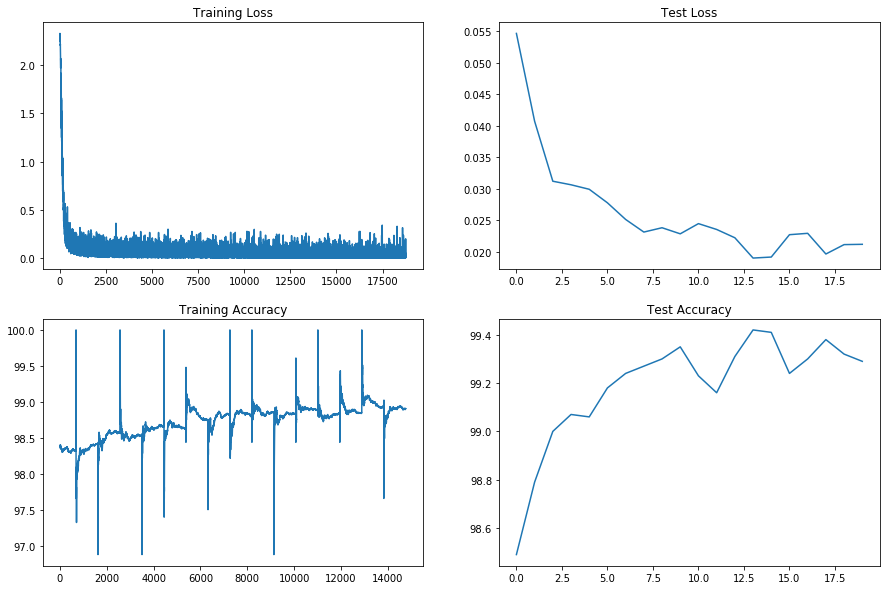

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [7]:
l1_weight = 0.00005

In [8]:
dropout_value = 0.1
class Net6(nn.Module):
    def __init__(self):
        super(Net6, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [9]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model6 = Net6().to(device)
summary(model6, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def l1_penalty(x):
    return torch.abs(x).sum()

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        to_reg = []
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        for param in model.parameters():
            to_reg.append(param.view(-1))
        l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        
        # Calculate loss
        loss = F.nll_loss(y_pred, target) + l1
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
model6 =  Net6().to(device)
optimizer = optim.SGD(model6.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model6, device, train_loader, optimizer, epoch)
    test(model6, device, test_loader)

EPOCH: 0


Loss=0.22454078495502472 Batch_id=937 Accuracy=87.32: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.58it/s]



Test set: Average loss: 0.0559, Accuracy: 9843/10000 (98.43%)

EPOCH: 1


Loss=0.054176803678274155 Batch_id=937 Accuracy=97.47: 100%|█████████████████████████| 938/938 [00:19<00:00, 47.50it/s]



Test set: Average loss: 0.0423, Accuracy: 9888/10000 (98.88%)

EPOCH: 2


Loss=0.23705989122390747 Batch_id=937 Accuracy=97.86: 100%|██████████████████████████| 938/938 [00:21<00:00, 43.67it/s]



Test set: Average loss: 0.0317, Accuracy: 9901/10000 (99.01%)

EPOCH: 3


Loss=0.05338922142982483 Batch_id=937 Accuracy=98.08: 100%|██████████████████████████| 938/938 [00:19<00:00, 57.94it/s]



Test set: Average loss: 0.0334, Accuracy: 9897/10000 (98.97%)

EPOCH: 4


Loss=0.11375100910663605 Batch_id=937 Accuracy=98.25: 100%|██████████████████████████| 938/938 [00:20<00:00, 46.77it/s]



Test set: Average loss: 0.0279, Accuracy: 9923/10000 (99.23%)

EPOCH: 5


Loss=0.04160257428884506 Batch_id=937 Accuracy=98.36: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.10it/s]



Test set: Average loss: 0.0270, Accuracy: 9922/10000 (99.22%)

EPOCH: 6


Loss=0.3065418303012848 Batch_id=937 Accuracy=98.49: 100%|███████████████████████████| 938/938 [00:17<00:00, 52.45it/s]



Test set: Average loss: 0.0277, Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.12517787516117096 Batch_id=937 Accuracy=98.50: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.18it/s]



Test set: Average loss: 0.0253, Accuracy: 9918/10000 (99.18%)

EPOCH: 8


Loss=0.03975984454154968 Batch_id=937 Accuracy=98.51: 100%|██████████████████████████| 938/938 [00:18<00:00, 61.95it/s]



Test set: Average loss: 0.0266, Accuracy: 9925/10000 (99.25%)

EPOCH: 9


Loss=0.05976150184869766 Batch_id=937 Accuracy=98.56: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.87it/s]



Test set: Average loss: 0.0241, Accuracy: 9936/10000 (99.36%)

EPOCH: 10


Loss=0.057773638516664505 Batch_id=937 Accuracy=98.62: 100%|█████████████████████████| 938/938 [00:17<00:00, 54.08it/s]



Test set: Average loss: 0.0239, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.13297328352928162 Batch_id=937 Accuracy=98.74: 100%|██████████████████████████| 938/938 [00:17<00:00, 54.27it/s]



Test set: Average loss: 0.0254, Accuracy: 9916/10000 (99.16%)

EPOCH: 12


Loss=0.06373944133520126 Batch_id=937 Accuracy=98.66: 100%|██████████████████████████| 938/938 [00:17<00:00, 54.89it/s]



Test set: Average loss: 0.0231, Accuracy: 9929/10000 (99.29%)

EPOCH: 13


Loss=0.07479830831289291 Batch_id=937 Accuracy=98.72: 100%|██████████████████████████| 938/938 [00:18<00:00, 49.85it/s]



Test set: Average loss: 0.0216, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.17649628221988678 Batch_id=937 Accuracy=98.80: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.45it/s]



Test set: Average loss: 0.0193, Accuracy: 9944/10000 (99.44%)

EPOCH: 15


Loss=0.05677713826298714 Batch_id=937 Accuracy=98.73: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.80it/s]



Test set: Average loss: 0.0252, Accuracy: 9917/10000 (99.17%)

EPOCH: 16


Loss=0.0397857129573822 Batch_id=937 Accuracy=98.77: 100%|███████████████████████████| 938/938 [00:17<00:00, 53.20it/s]



Test set: Average loss: 0.0235, Accuracy: 9931/10000 (99.31%)

EPOCH: 17


Loss=0.17445620894432068 Batch_id=937 Accuracy=98.76: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.64it/s]



Test set: Average loss: 0.0198, Accuracy: 9939/10000 (99.39%)

EPOCH: 18


Loss=0.05314607173204422 Batch_id=937 Accuracy=98.75: 100%|██████████████████████████| 938/938 [00:16<00:00, 64.11it/s]



Test set: Average loss: 0.0229, Accuracy: 9931/10000 (99.31%)

EPOCH: 19


Loss=0.06475440412759781 Batch_id=937 Accuracy=98.77: 100%|██████████████████████████| 938/938 [00:16<00:00, 55.36it/s]



Test set: Average loss: 0.0216, Accuracy: 9929/10000 (99.29%)



Text(0.5, 1.0, 'Test Accuracy')

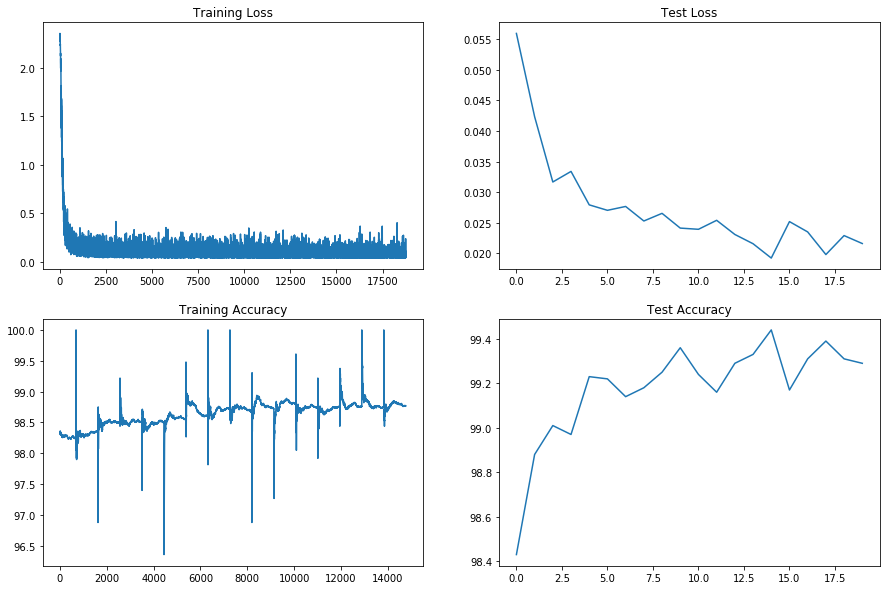

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [7]:
l1_weight = 0.000025 ##Appears to be the best with the reference NW we have used here

In [8]:
dropout_value = 0.1
class Net7(nn.Module):
    def __init__(self):
        super(Net7, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [9]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model7 = Net7().to(device)
summary(model7, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def l1_penalty(x):
    return torch.abs(x).sum()

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        to_reg = []
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        for param in model.parameters():
            to_reg.append(param.view(-1))
        l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        
        # Calculate loss
        loss = F.nll_loss(y_pred, target) + l1
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
model7 =  Net7().to(device)
optimizer = optim.SGD(model7.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model7, device, train_loader, optimizer, epoch)
    test(model7, device, test_loader)

EPOCH: 0


Loss=0.2014085352420807 Batch_id=937 Accuracy=87.37: 100%|███████████████████████████| 938/938 [00:17<00:00, 52.85it/s]



Test set: Average loss: 0.0528, Accuracy: 9857/10000 (98.57%)

EPOCH: 1


Loss=0.042714085429906845 Batch_id=937 Accuracy=97.41: 100%|█████████████████████████| 938/938 [00:17<00:00, 52.51it/s]



Test set: Average loss: 0.0378, Accuracy: 9883/10000 (98.83%)

EPOCH: 2


Loss=0.21336904168128967 Batch_id=937 Accuracy=97.89: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.96it/s]



Test set: Average loss: 0.0348, Accuracy: 9897/10000 (98.97%)

EPOCH: 3


Loss=0.038878392428159714 Batch_id=937 Accuracy=98.12: 100%|█████████████████████████| 938/938 [00:17<00:00, 59.96it/s]



Test set: Average loss: 0.0346, Accuracy: 9893/10000 (98.93%)

EPOCH: 4


Loss=0.060501039028167725 Batch_id=937 Accuracy=98.31: 100%|█████████████████████████| 938/938 [00:18<00:00, 59.06it/s]



Test set: Average loss: 0.0282, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


Loss=0.028877107426524162 Batch_id=937 Accuracy=98.39: 100%|█████████████████████████| 938/938 [00:17<00:00, 61.64it/s]



Test set: Average loss: 0.0276, Accuracy: 9920/10000 (99.20%)

EPOCH: 6


Loss=0.2728198766708374 Batch_id=937 Accuracy=98.47: 100%|███████████████████████████| 938/938 [00:18<00:00, 50.77it/s]



Test set: Average loss: 0.0258, Accuracy: 9924/10000 (99.24%)

EPOCH: 7


Loss=0.08864489197731018 Batch_id=937 Accuracy=98.52: 100%|██████████████████████████| 938/938 [00:18<00:00, 49.84it/s]



Test set: Average loss: 0.0237, Accuracy: 9926/10000 (99.26%)

EPOCH: 8


Loss=0.02642343007028103 Batch_id=937 Accuracy=98.59: 100%|██████████████████████████| 938/938 [00:19<00:00, 49.11it/s]



Test set: Average loss: 0.0244, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.02811882458627224 Batch_id=937 Accuracy=98.59: 100%|██████████████████████████| 938/938 [00:19<00:00, 48.50it/s]



Test set: Average loss: 0.0229, Accuracy: 9938/10000 (99.38%)

EPOCH: 10


Loss=0.031091349199414253 Batch_id=937 Accuracy=98.71: 100%|█████████████████████████| 938/938 [00:19<00:00, 48.94it/s]



Test set: Average loss: 0.0236, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.08279016613960266 Batch_id=937 Accuracy=98.72: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.99it/s]



Test set: Average loss: 0.0235, Accuracy: 9925/10000 (99.25%)

EPOCH: 12


Loss=0.03089049831032753 Batch_id=937 Accuracy=98.78: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.81it/s]



Test set: Average loss: 0.0222, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.07532990723848343 Batch_id=937 Accuracy=98.74: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.10it/s]



Test set: Average loss: 0.0191, Accuracy: 9946/10000 (99.46%)

EPOCH: 14


Loss=0.1691276580095291 Batch_id=937 Accuracy=98.82: 100%|███████████████████████████| 938/938 [00:17<00:00, 54.05it/s]



Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 15


Loss=0.04073772951960564 Batch_id=937 Accuracy=98.83: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.89it/s]



Test set: Average loss: 0.0224, Accuracy: 9931/10000 (99.31%)

EPOCH: 16


Loss=0.023147927597165108 Batch_id=937 Accuracy=98.80: 100%|█████████████████████████| 938/938 [00:17<00:00, 62.78it/s]



Test set: Average loss: 0.0211, Accuracy: 9928/10000 (99.28%)

EPOCH: 17


Loss=0.12181268632411957 Batch_id=937 Accuracy=98.83: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.41it/s]



Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.37%)

EPOCH: 18


Loss=0.02855561673641205 Batch_id=937 Accuracy=98.88: 100%|██████████████████████████| 938/938 [00:20<00:00, 44.79it/s]



Test set: Average loss: 0.0204, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=0.04911252111196518 Batch_id=937 Accuracy=98.86: 100%|██████████████████████████| 938/938 [00:18<00:00, 49.51it/s]



Test set: Average loss: 0.0203, Accuracy: 9928/10000 (99.28%)



Text(0.5, 1.0, 'Test Accuracy')

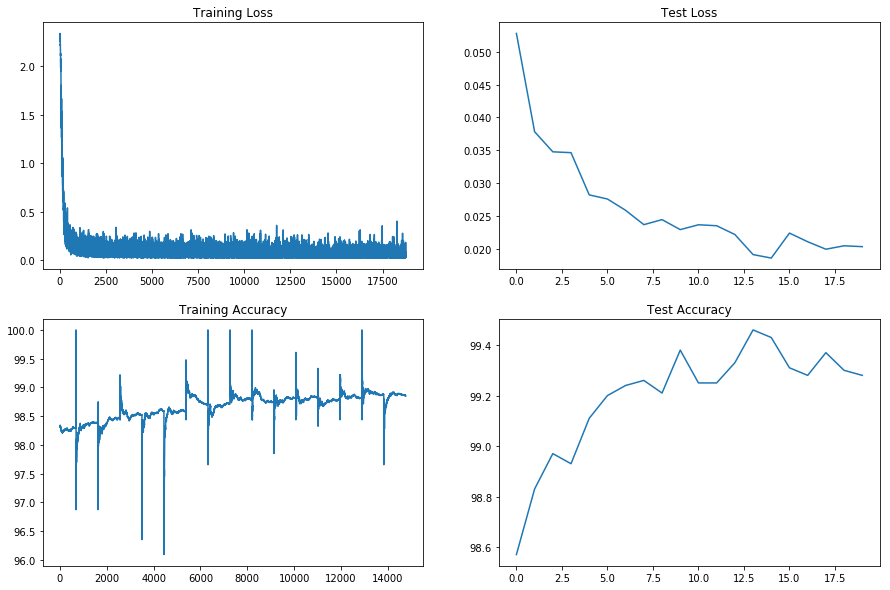

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [7]:
l1_weight = 0.0000125

In [8]:
dropout_value = 0.1
class Net8(nn.Module):
    def __init__(self):
        super(Net8, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [9]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model8 = Net8().to(device)
summary(model8, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def l1_penalty(x):
    return torch.abs(x).sum()

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        to_reg = []
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        for param in model.parameters():
            to_reg.append(param.view(-1))
        l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        
        # Calculate loss
        loss = F.nll_loss(y_pred, target) + l1
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
model8 =  Net8().to(device)
optimizer = optim.SGD(model8.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model8, device, train_loader, optimizer, epoch)
    test(model8, device, test_loader)

EPOCH: 0


Loss=0.1935102343559265 Batch_id=937 Accuracy=87.32: 100%|███████████████████████████| 938/938 [00:17<00:00, 58.89it/s]



Test set: Average loss: 0.0587, Accuracy: 9830/10000 (98.30%)

EPOCH: 1


Loss=0.028757210820913315 Batch_id=937 Accuracy=97.43: 100%|█████████████████████████| 938/938 [00:17<00:00, 52.86it/s]



Test set: Average loss: 0.0413, Accuracy: 9877/10000 (98.77%)

EPOCH: 2


Loss=0.2227877974510193 Batch_id=937 Accuracy=97.96: 100%|███████████████████████████| 938/938 [00:18<00:00, 51.26it/s]



Test set: Average loss: 0.0325, Accuracy: 9900/10000 (99.00%)

EPOCH: 3


Loss=0.028689434751868248 Batch_id=937 Accuracy=98.13: 100%|█████████████████████████| 938/938 [00:17<00:00, 53.10it/s]



Test set: Average loss: 0.0308, Accuracy: 9905/10000 (99.05%)

EPOCH: 4


Loss=0.0484880767762661 Batch_id=937 Accuracy=98.26: 100%|███████████████████████████| 938/938 [00:17<00:00, 52.43it/s]



Test set: Average loss: 0.0275, Accuracy: 9919/10000 (99.19%)

EPOCH: 5


Loss=0.01416002307087183 Batch_id=937 Accuracy=98.44: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.16it/s]



Test set: Average loss: 0.0277, Accuracy: 9921/10000 (99.21%)

EPOCH: 6


Loss=0.26366034150123596 Batch_id=937 Accuracy=98.50: 100%|██████████████████████████| 938/938 [00:18<00:00, 57.82it/s]



Test set: Average loss: 0.0255, Accuracy: 9928/10000 (99.28%)

EPOCH: 7


Loss=0.07630414515733719 Batch_id=937 Accuracy=98.55: 100%|██████████████████████████| 938/938 [00:18<00:00, 54.13it/s]



Test set: Average loss: 0.0238, Accuracy: 9919/10000 (99.19%)

EPOCH: 8


Loss=0.015105042606592178 Batch_id=937 Accuracy=98.61: 100%|█████████████████████████| 938/938 [00:18<00:00, 51.04it/s]



Test set: Average loss: 0.0233, Accuracy: 9928/10000 (99.28%)

EPOCH: 9


Loss=0.01914055645465851 Batch_id=937 Accuracy=98.67: 100%|██████████████████████████| 938/938 [00:19<00:00, 48.01it/s]



Test set: Average loss: 0.0236, Accuracy: 9930/10000 (99.30%)

EPOCH: 10


Loss=0.02951608970761299 Batch_id=937 Accuracy=98.73: 100%|██████████████████████████| 938/938 [00:19<00:00, 49.06it/s]



Test set: Average loss: 0.0241, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.0688265711069107 Batch_id=937 Accuracy=98.83: 100%|███████████████████████████| 938/938 [00:18<00:00, 51.08it/s]



Test set: Average loss: 0.0230, Accuracy: 9920/10000 (99.20%)

EPOCH: 12


Loss=0.022141167894005775 Batch_id=937 Accuracy=98.76: 100%|█████████████████████████| 938/938 [00:18<00:00, 51.08it/s]



Test set: Average loss: 0.0205, Accuracy: 9935/10000 (99.35%)

EPOCH: 13


Loss=0.07220632582902908 Batch_id=937 Accuracy=98.81: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.06it/s]



Test set: Average loss: 0.0199, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Loss=0.21460531651973724 Batch_id=937 Accuracy=98.86: 100%|██████████████████████████| 938/938 [00:18<00:00, 58.43it/s]



Test set: Average loss: 0.0183, Accuracy: 9938/10000 (99.38%)

EPOCH: 15


Loss=0.06021833419799805 Batch_id=937 Accuracy=98.88: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.86it/s]



Test set: Average loss: 0.0240, Accuracy: 9920/10000 (99.20%)

EPOCH: 16


Loss=0.013709728606045246 Batch_id=937 Accuracy=98.88: 100%|█████████████████████████| 938/938 [00:18<00:00, 50.54it/s]



Test set: Average loss: 0.0217, Accuracy: 9933/10000 (99.33%)

EPOCH: 17


Loss=0.08919266611337662 Batch_id=937 Accuracy=98.86: 100%|██████████████████████████| 938/938 [00:19<00:00, 48.38it/s]



Test set: Average loss: 0.0199, Accuracy: 9936/10000 (99.36%)

EPOCH: 18


Loss=0.03993496298789978 Batch_id=937 Accuracy=98.89: 100%|██████████████████████████| 938/938 [00:19<00:00, 49.33it/s]



Test set: Average loss: 0.0206, Accuracy: 9936/10000 (99.36%)

EPOCH: 19


Loss=0.028001461178064346 Batch_id=937 Accuracy=98.92: 100%|█████████████████████████| 938/938 [00:17<00:00, 52.84it/s]



Test set: Average loss: 0.0194, Accuracy: 9939/10000 (99.39%)



Text(0.5, 1.0, 'Test Accuracy')

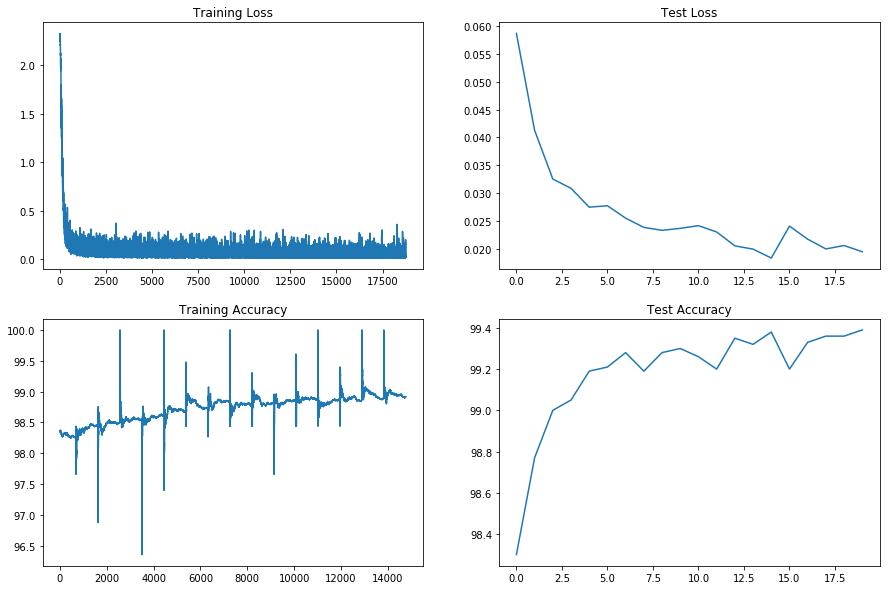

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [7]:
l1_weight = 0.0000375

In [8]:
dropout_value = 0.1
class Net9(nn.Module):
    def __init__(self):
        super(Net9, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [9]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model9 = Net9().to(device)
summary(model9, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def l1_penalty(x):
    return torch.abs(x).sum()

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        to_reg = []
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        for param in model.parameters():
            to_reg.append(param.view(-1))
        l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        
        # Calculate loss
        loss = F.nll_loss(y_pred, target) + l1
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
model9 =  Net9().to(device)
optimizer = optim.SGD(model9.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model9, device, train_loader, optimizer, epoch)
    test(model9, device, test_loader)

EPOCH: 0


Loss=0.21814429759979248 Batch_id=937 Accuracy=87.33: 100%|██████████████████████████| 938/938 [00:17<00:00, 53.05it/s]



Test set: Average loss: 0.0559, Accuracy: 9846/10000 (98.46%)

EPOCH: 1


Loss=0.04485241323709488 Batch_id=937 Accuracy=97.43: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.46it/s]



Test set: Average loss: 0.0399, Accuracy: 9866/10000 (98.66%)

EPOCH: 2


Loss=0.21424271166324615 Batch_id=937 Accuracy=97.88: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.34it/s]



Test set: Average loss: 0.0321, Accuracy: 9905/10000 (99.05%)

EPOCH: 3


Loss=0.04507114738225937 Batch_id=937 Accuracy=98.09: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.51it/s]



Test set: Average loss: 0.0338, Accuracy: 9899/10000 (98.99%)

EPOCH: 4


Loss=0.08717089891433716 Batch_id=937 Accuracy=98.30: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.03it/s]



Test set: Average loss: 0.0288, Accuracy: 9913/10000 (99.13%)

EPOCH: 5


Loss=0.037198323756456375 Batch_id=937 Accuracy=98.37: 100%|█████████████████████████| 938/938 [00:17<00:00, 52.29it/s]



Test set: Average loss: 0.0284, Accuracy: 9918/10000 (99.18%)

EPOCH: 6


Loss=0.30477768182754517 Batch_id=937 Accuracy=98.55: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.12it/s]



Test set: Average loss: 0.0261, Accuracy: 9920/10000 (99.20%)

EPOCH: 7


Loss=0.10378026217222214 Batch_id=937 Accuracy=98.56: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.28it/s]



Test set: Average loss: 0.0246, Accuracy: 9918/10000 (99.18%)

EPOCH: 8


Loss=0.03305687755346298 Batch_id=937 Accuracy=98.56: 100%|██████████████████████████| 938/938 [00:17<00:00, 64.89it/s]



Test set: Average loss: 0.0257, Accuracy: 9920/10000 (99.20%)

EPOCH: 9


Loss=0.05211663991212845 Batch_id=937 Accuracy=98.59: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.85it/s]



Test set: Average loss: 0.0236, Accuracy: 9929/10000 (99.29%)

EPOCH: 10


Loss=0.045177869498729706 Batch_id=937 Accuracy=98.67: 100%|█████████████████████████| 938/938 [00:18<00:00, 50.78it/s]



Test set: Average loss: 0.0240, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.16840222477912903 Batch_id=937 Accuracy=98.72: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.63it/s]



Test set: Average loss: 0.0254, Accuracy: 9922/10000 (99.22%)

EPOCH: 12


Loss=0.04552704095840454 Batch_id=937 Accuracy=98.72: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.56it/s]



Test set: Average loss: 0.0224, Accuracy: 9923/10000 (99.23%)

EPOCH: 13


Loss=0.08860556036233902 Batch_id=937 Accuracy=98.72: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.66it/s]



Test set: Average loss: 0.0216, Accuracy: 9928/10000 (99.28%)

EPOCH: 14


Loss=0.1917738914489746 Batch_id=937 Accuracy=98.81: 100%|███████████████████████████| 938/938 [00:18<00:00, 63.99it/s]



Test set: Average loss: 0.0183, Accuracy: 9942/10000 (99.42%)

EPOCH: 15


Loss=0.07795123755931854 Batch_id=937 Accuracy=98.80: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.31it/s]



Test set: Average loss: 0.0241, Accuracy: 9920/10000 (99.20%)

EPOCH: 16


Loss=0.03153018653392792 Batch_id=937 Accuracy=98.80: 100%|██████████████████████████| 938/938 [00:18<00:00, 49.44it/s]



Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)

EPOCH: 17


Loss=0.17225268483161926 Batch_id=937 Accuracy=98.77: 100%|██████████████████████████| 938/938 [00:18<00:00, 49.91it/s]



Test set: Average loss: 0.0190, Accuracy: 9941/10000 (99.41%)

EPOCH: 18


Loss=0.05381359905004501 Batch_id=937 Accuracy=98.86: 100%|██████████████████████████| 938/938 [00:19<00:00, 49.32it/s]



Test set: Average loss: 0.0206, Accuracy: 9933/10000 (99.33%)

EPOCH: 19


Loss=0.05102066695690155 Batch_id=937 Accuracy=98.86: 100%|██████████████████████████| 938/938 [00:18<00:00, 55.64it/s]



Test set: Average loss: 0.0203, Accuracy: 9932/10000 (99.32%)



Text(0.5, 1.0, 'Test Accuracy')

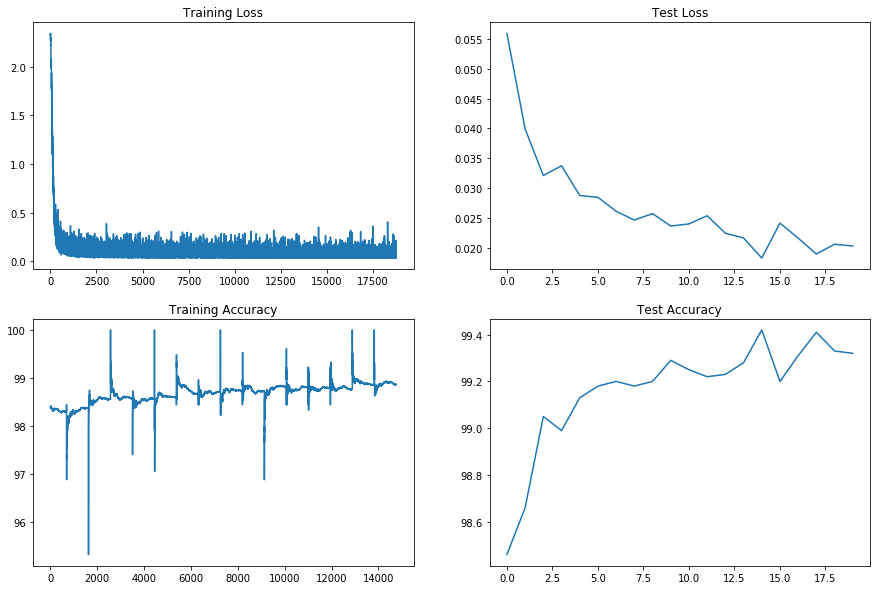

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [7]:
l1_weight = 0.00003125

In [8]:
dropout_value = 0.1
class Net10(nn.Module):
    def __init__(self):
        super(Net10, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [9]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model10 = Net10().to(device)
summary(model10, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def l1_penalty(x):
    return torch.abs(x).sum()

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        to_reg = []
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        for param in model.parameters():
            to_reg.append(param.view(-1))
        l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        
        # Calculate loss
        loss = F.nll_loss(y_pred, target) + l1
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
model10 =  Net10().to(device)
optimizer = optim.SGD(model10.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model10, device, train_loader, optimizer, epoch)
    test(model10, device, test_loader)

EPOCH: 0


Loss=0.21770556271076202 Batch_id=937 Accuracy=87.38: 100%|██████████████████████████| 938/938 [00:17<00:00, 52.66it/s]



Test set: Average loss: 0.0551, Accuracy: 9847/10000 (98.47%)

EPOCH: 1


Loss=0.04981298744678497 Batch_id=937 Accuracy=97.40: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.92it/s]



Test set: Average loss: 0.0376, Accuracy: 9890/10000 (98.90%)

EPOCH: 2


Loss=0.21484561264514923 Batch_id=937 Accuracy=97.95: 100%|██████████████████████████| 938/938 [00:17<00:00, 58.20it/s]



Test set: Average loss: 0.0332, Accuracy: 9900/10000 (99.00%)

EPOCH: 3


Loss=0.039491478353738785 Batch_id=937 Accuracy=98.13: 100%|█████████████████████████| 938/938 [00:18<00:00, 56.87it/s]



Test set: Average loss: 0.0335, Accuracy: 9892/10000 (98.92%)

EPOCH: 4


Loss=0.061260029673576355 Batch_id=937 Accuracy=98.28: 100%|█████████████████████████| 938/938 [00:18<00:00, 50.58it/s]



Test set: Average loss: 0.0299, Accuracy: 9913/10000 (99.13%)

EPOCH: 5


Loss=0.033581189811229706 Batch_id=937 Accuracy=98.37: 100%|█████████████████████████| 938/938 [00:18<00:00, 50.72it/s]



Test set: Average loss: 0.0275, Accuracy: 9923/10000 (99.23%)

EPOCH: 6


Loss=0.2702391445636749 Batch_id=937 Accuracy=98.50: 100%|███████████████████████████| 938/938 [00:18<00:00, 50.59it/s]



Test set: Average loss: 0.0272, Accuracy: 9922/10000 (99.22%)

EPOCH: 7


Loss=0.09560178220272064 Batch_id=937 Accuracy=98.52: 100%|██████████████████████████| 938/938 [00:19<00:00, 49.13it/s]



Test set: Average loss: 0.0243, Accuracy: 9925/10000 (99.25%)

EPOCH: 8


Loss=0.02859823778271675 Batch_id=937 Accuracy=98.60: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.97it/s]



Test set: Average loss: 0.0257, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


Loss=0.040090739727020264 Batch_id=937 Accuracy=98.64: 100%|█████████████████████████| 938/938 [00:18<00:00, 56.75it/s]



Test set: Average loss: 0.0240, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.04781348258256912 Batch_id=937 Accuracy=98.66: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.11it/s]



Test set: Average loss: 0.0251, Accuracy: 9922/10000 (99.22%)

EPOCH: 11


Loss=0.08769728243350983 Batch_id=937 Accuracy=98.77: 100%|██████████████████████████| 938/938 [00:18<00:00, 58.79it/s]



Test set: Average loss: 0.0244, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.04627615958452225 Batch_id=937 Accuracy=98.73: 100%|██████████████████████████| 938/938 [00:18<00:00, 57.78it/s]



Test set: Average loss: 0.0233, Accuracy: 9931/10000 (99.31%)

EPOCH: 13


Loss=0.08656014502048492 Batch_id=937 Accuracy=98.77: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.79it/s]



Test set: Average loss: 0.0220, Accuracy: 9927/10000 (99.27%)

EPOCH: 14


Loss=0.22859475016593933 Batch_id=937 Accuracy=98.79: 100%|██████████████████████████| 938/938 [00:18<00:00, 49.56it/s]



Test set: Average loss: 0.0195, Accuracy: 9942/10000 (99.42%)

EPOCH: 15


Loss=0.0691232979297638 Batch_id=937 Accuracy=98.80: 100%|███████████████████████████| 938/938 [00:18<00:00, 57.84it/s]



Test set: Average loss: 0.0241, Accuracy: 9923/10000 (99.23%)

EPOCH: 16


Loss=0.02849629521369934 Batch_id=937 Accuracy=98.83: 100%|██████████████████████████| 938/938 [00:18<00:00, 50.69it/s]



Test set: Average loss: 0.0226, Accuracy: 9930/10000 (99.30%)

EPOCH: 17


Loss=0.14233824610710144 Batch_id=937 Accuracy=98.80: 100%|██████████████████████████| 938/938 [00:18<00:00, 55.54it/s]



Test set: Average loss: 0.0191, Accuracy: 9938/10000 (99.38%)

EPOCH: 18


Loss=0.05179719626903534 Batch_id=937 Accuracy=98.84: 100%|██████████████████████████| 938/938 [00:18<00:00, 49.99it/s]



Test set: Average loss: 0.0203, Accuracy: 9933/10000 (99.33%)

EPOCH: 19


Loss=0.08636489510536194 Batch_id=937 Accuracy=98.86: 100%|██████████████████████████| 938/938 [00:19<00:00, 49.22it/s]



Test set: Average loss: 0.0199, Accuracy: 9930/10000 (99.30%)



Text(0.5, 1.0, 'Test Accuracy')

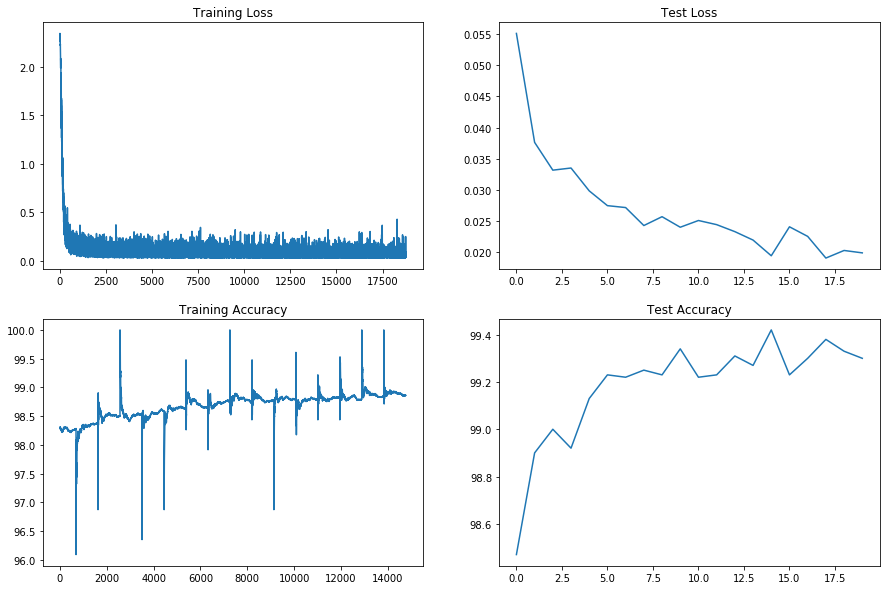

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [7]:
l1_weight = 0.0000255

In [8]:
dropout_value = 0.1
class Net11(nn.Module):
    def __init__(self):
        super(Net11, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [9]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model11 = Net11().to(device)
summary(model11, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def l1_penalty(x):
    return torch.abs(x).sum()

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        to_reg = []
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        for param in model.parameters():
            to_reg.append(param.view(-1))
        l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        
        # Calculate loss
        loss = F.nll_loss(y_pred, target) + l1
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
model11 =  Net11().to(device)
optimizer = optim.SGD(model11.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model11, device, train_loader, optimizer, epoch)
    test(model11, device, test_loader)

EPOCH: 0


Loss=0.19426418840885162 Batch_id=937 Accuracy=87.29: 100%|██████████████████████████| 938/938 [00:18<00:00, 58.59it/s]



Test set: Average loss: 0.0564, Accuracy: 9846/10000 (98.46%)

EPOCH: 1


Loss=0.0435972660779953 Batch_id=937 Accuracy=97.40: 100%|███████████████████████████| 938/938 [00:26<00:00, 36.59it/s]



Test set: Average loss: 0.0398, Accuracy: 9887/10000 (98.87%)

EPOCH: 2


Loss=0.2021765112876892 Batch_id=937 Accuracy=97.86: 100%|███████████████████████████| 938/938 [00:27<00:00, 33.86it/s]



Test set: Average loss: 0.0320, Accuracy: 9903/10000 (99.03%)

EPOCH: 3


Loss=0.037311404943466187 Batch_id=937 Accuracy=98.12: 100%|█████████████████████████| 938/938 [00:26<00:00, 35.60it/s]



Test set: Average loss: 0.0336, Accuracy: 9898/10000 (98.98%)

EPOCH: 4


Loss=0.12150687724351883 Batch_id=937 Accuracy=98.26: 100%|██████████████████████████| 938/938 [00:25<00:00, 37.88it/s]



Test set: Average loss: 0.0281, Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.029159875586628914 Batch_id=937 Accuracy=98.38: 100%|█████████████████████████| 938/938 [00:26<00:00, 41.71it/s]



Test set: Average loss: 0.0254, Accuracy: 9930/10000 (99.30%)

EPOCH: 6


Loss=0.22141052782535553 Batch_id=937 Accuracy=98.50: 100%|██████████████████████████| 938/938 [00:26<00:00, 35.46it/s]



Test set: Average loss: 0.0261, Accuracy: 9920/10000 (99.20%)

EPOCH: 7


Loss=0.10702617466449738 Batch_id=937 Accuracy=98.59: 100%|██████████████████████████| 938/938 [00:25<00:00, 36.21it/s]



Test set: Average loss: 0.0242, Accuracy: 9916/10000 (99.16%)

EPOCH: 8


Loss=0.02524469420313835 Batch_id=937 Accuracy=98.58: 100%|██████████████████████████| 938/938 [00:26<00:00, 35.83it/s]



Test set: Average loss: 0.0240, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.0375494584441185 Batch_id=937 Accuracy=98.57: 100%|███████████████████████████| 938/938 [00:25<00:00, 43.14it/s]



Test set: Average loss: 0.0235, Accuracy: 9927/10000 (99.27%)

EPOCH: 10


Loss=0.08379797637462616 Batch_id=937 Accuracy=98.65: 100%|██████████████████████████| 938/938 [00:26<00:00, 35.39it/s]



Test set: Average loss: 0.0227, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.11679580807685852 Batch_id=937 Accuracy=98.73: 100%|██████████████████████████| 938/938 [00:25<00:00, 36.37it/s]



Test set: Average loss: 0.0246, Accuracy: 9916/10000 (99.16%)

EPOCH: 12


Loss=0.032254334539175034 Batch_id=937 Accuracy=98.77: 100%|█████████████████████████| 938/938 [00:26<00:00, 34.95it/s]



Test set: Average loss: 0.0203, Accuracy: 9934/10000 (99.34%)

EPOCH: 13


Loss=0.05572193115949631 Batch_id=937 Accuracy=98.81: 100%|██████████████████████████| 938/938 [00:26<00:00, 35.40it/s]



Test set: Average loss: 0.0191, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.19869931042194366 Batch_id=937 Accuracy=98.81: 100%|██████████████████████████| 938/938 [00:26<00:00, 35.59it/s]



Test set: Average loss: 0.0187, Accuracy: 9943/10000 (99.43%)

EPOCH: 15


Loss=0.06042283773422241 Batch_id=937 Accuracy=98.87: 100%|██████████████████████████| 938/938 [00:26<00:00, 35.00it/s]



Test set: Average loss: 0.0228, Accuracy: 9921/10000 (99.21%)

EPOCH: 16


Loss=0.02344864048063755 Batch_id=937 Accuracy=98.87: 100%|██████████████████████████| 938/938 [00:28<00:00, 33.28it/s]



Test set: Average loss: 0.0222, Accuracy: 9926/10000 (99.26%)

EPOCH: 17


Loss=0.15033747255802155 Batch_id=937 Accuracy=98.81: 100%|██████████████████████████| 938/938 [00:26<00:00, 35.22it/s]



Test set: Average loss: 0.0204, Accuracy: 9933/10000 (99.33%)

EPOCH: 18


Loss=0.03597637265920639 Batch_id=937 Accuracy=98.82: 100%|██████████████████████████| 938/938 [00:26<00:00, 34.86it/s]



Test set: Average loss: 0.0197, Accuracy: 9939/10000 (99.39%)

EPOCH: 19


Loss=0.07847985625267029 Batch_id=937 Accuracy=98.86: 100%|██████████████████████████| 938/938 [00:26<00:00, 41.94it/s]



Test set: Average loss: 0.0193, Accuracy: 9931/10000 (99.31%)

EPOCH: 20


Loss=0.027749165892601013 Batch_id=937 Accuracy=98.89: 100%|█████████████████████████| 938/938 [00:26<00:00, 40.94it/s]



Test set: Average loss: 0.0184, Accuracy: 9939/10000 (99.39%)

EPOCH: 21


Loss=0.027499262243509293 Batch_id=937 Accuracy=98.90: 100%|█████████████████████████| 938/938 [00:26<00:00, 37.13it/s]



Test set: Average loss: 0.0254, Accuracy: 9914/10000 (99.14%)

EPOCH: 22


Loss=0.02552756294608116 Batch_id=937 Accuracy=98.96: 100%|██████████████████████████| 938/938 [00:27<00:00, 34.69it/s]



Test set: Average loss: 0.0197, Accuracy: 9940/10000 (99.40%)

EPOCH: 23


Loss=0.05589579418301582 Batch_id=937 Accuracy=98.89: 100%|██████████████████████████| 938/938 [00:27<00:00, 34.41it/s]



Test set: Average loss: 0.0196, Accuracy: 9936/10000 (99.36%)

EPOCH: 24


Loss=0.047716327011585236 Batch_id=937 Accuracy=98.95: 100%|█████████████████████████| 938/938 [00:27<00:00, 34.56it/s]



Test set: Average loss: 0.0223, Accuracy: 9921/10000 (99.21%)

EPOCH: 25


Loss=0.031194834038615227 Batch_id=937 Accuracy=98.88: 100%|█████████████████████████| 938/938 [00:27<00:00, 34.60it/s]



Test set: Average loss: 0.0176, Accuracy: 9942/10000 (99.42%)

EPOCH: 26


Loss=0.13306695222854614 Batch_id=937 Accuracy=98.99: 100%|██████████████████████████| 938/938 [00:27<00:00, 34.59it/s]



Test set: Average loss: 0.0198, Accuracy: 9940/10000 (99.40%)

EPOCH: 27


Loss=0.033811721950769424 Batch_id=937 Accuracy=98.97: 100%|█████████████████████████| 938/938 [00:26<00:00, 34.92it/s]



Test set: Average loss: 0.0201, Accuracy: 9940/10000 (99.40%)

EPOCH: 28


Loss=0.028291814029216766 Batch_id=937 Accuracy=99.01: 100%|█████████████████████████| 938/938 [00:26<00:00, 34.81it/s]



Test set: Average loss: 0.0229, Accuracy: 9929/10000 (99.29%)

EPOCH: 29


Loss=0.02863159216940403 Batch_id=937 Accuracy=98.93: 100%|██████████████████████████| 938/938 [00:27<00:00, 34.56it/s]



Test set: Average loss: 0.0192, Accuracy: 9935/10000 (99.35%)

EPOCH: 30


Loss=0.06362327933311462 Batch_id=937 Accuracy=99.00: 100%|██████████████████████████| 938/938 [00:26<00:00, 35.37it/s]



Test set: Average loss: 0.0220, Accuracy: 9928/10000 (99.28%)

EPOCH: 31


Loss=0.04595155268907547 Batch_id=937 Accuracy=98.98: 100%|██████████████████████████| 938/938 [00:26<00:00, 40.85it/s]



Test set: Average loss: 0.0204, Accuracy: 9932/10000 (99.32%)

EPOCH: 32


Loss=0.02991146594285965 Batch_id=937 Accuracy=98.96: 100%|██████████████████████████| 938/938 [00:26<00:00, 35.23it/s]



Test set: Average loss: 0.0184, Accuracy: 9945/10000 (99.45%)

EPOCH: 33


Loss=0.08501230925321579 Batch_id=937 Accuracy=99.00: 100%|██████████████████████████| 938/938 [00:26<00:00, 35.37it/s]



Test set: Average loss: 0.0167, Accuracy: 9945/10000 (99.45%)

EPOCH: 34


Loss=0.040630027651786804 Batch_id=937 Accuracy=99.04: 100%|█████████████████████████| 938/938 [00:26<00:00, 35.93it/s]



Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)

EPOCH: 35


Loss=0.14910683035850525 Batch_id=937 Accuracy=98.96: 100%|██████████████████████████| 938/938 [00:26<00:00, 40.38it/s]



Test set: Average loss: 0.0168, Accuracy: 9952/10000 (99.52%)

EPOCH: 36


Loss=0.03079374134540558 Batch_id=937 Accuracy=99.04: 100%|██████████████████████████| 938/938 [00:23<00:00, 40.46it/s]



Test set: Average loss: 0.0219, Accuracy: 9941/10000 (99.41%)

EPOCH: 37


Loss=0.08925244957208633 Batch_id=937 Accuracy=99.01: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.78it/s]



Test set: Average loss: 0.0203, Accuracy: 9934/10000 (99.34%)

EPOCH: 38


Loss=0.040380001068115234 Batch_id=937 Accuracy=99.03: 100%|█████████████████████████| 938/938 [00:17<00:00, 53.43it/s]



Test set: Average loss: 0.0199, Accuracy: 9941/10000 (99.41%)

EPOCH: 39


Loss=0.037225786596536636 Batch_id=937 Accuracy=99.06: 100%|█████████████████████████| 938/938 [00:17<00:00, 54.20it/s]



Test set: Average loss: 0.0215, Accuracy: 9935/10000 (99.35%)



Text(0.5, 1.0, 'Test Accuracy')

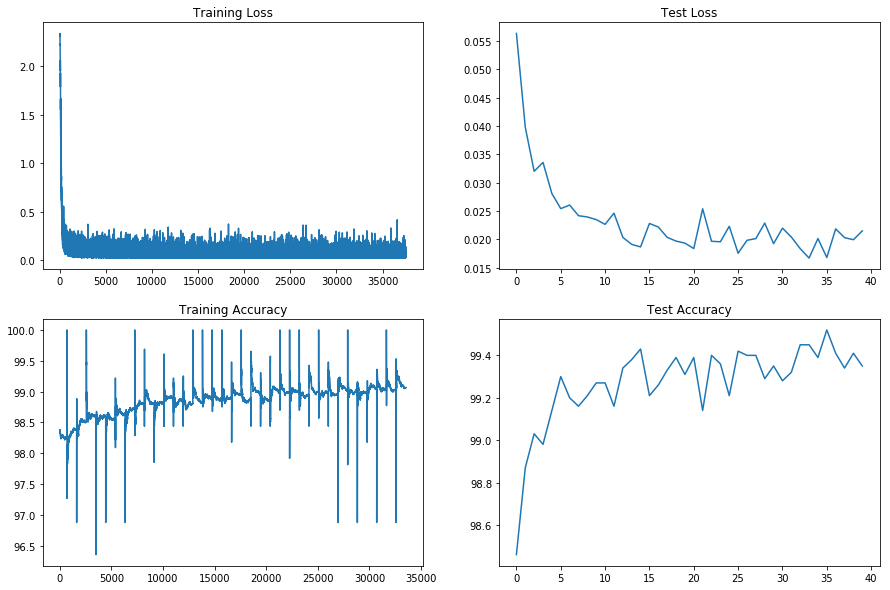

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [8]:
l1_weight = 0.000025

In [9]:
dropout_value = 0.1
class Net12(nn.Module):
    def __init__(self):
        super(Net12, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        )#input:28x28x1, output:26x26x8, RF:3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:26x26x8, output:24x24x8, RF:5x5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24x8, output:12x12x8, RF:6x6
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),
            nn.ReLU(),
        ) #input:12x12x8, output:12x12x8, RF:6x6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:12x12x8, output:10x10x16, RF:10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        )#input:10x10x16, output:8x8x16, RF:14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:8x8x16, output:6x6x16, RF:18x18
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU(),            
        ) #input:6x6x16, output:6x6x16, RF:22x22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6x16, output:1x1x16, RF:32x32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) #input:1x1x16, output:1x1x10,

    def forward(self, x):
        # Input Block
        x = self.convblock1(x)
        # CONVOLUTION BLOCK 1
        x = self.convblock2(x)
        # TRANSITION BLOCK 1
        x = self.pool1(x)
        x = self.convblock3(x)
        # CONVOLUTION BLOCK 2
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        # OUTPUT BLOCK
        x = self.gap(x)        
        x = self.convblock8(x)
        # Reshape
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [10]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model12 = Net12().to(device)
summary(model12, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
       BatchNorm2d-6            [-1, 8, 24, 24]              16
           Dropout-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              64
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def l1_penalty(x):
    return torch.abs(x).sum()

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        to_reg = []
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        for param in model.parameters():
            to_reg.append(param.view(-1))
        l1 = l1_weight*l1_penalty(torch.cat(to_reg))
        
        # Calculate loss
        loss = F.nll_loss(y_pred, target) + l1
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [12]:
model12 =  Net12().to(device)
optimizer = optim.SGD(model12.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 1
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model12, device, train_loader, optimizer, epoch)
    test(model12, device, test_loader)

EPOCH: 0


Loss=0.18929365277290344 Batch_id=937 Accuracy=87.29: 100%|██████████████████████████| 938/938 [00:18<00:00, 51.04it/s]



Test set: Average loss: 0.0567, Accuracy: 9841/10000 (98.41%)



Text(0.5, 1.0, 'Test Accuracy')

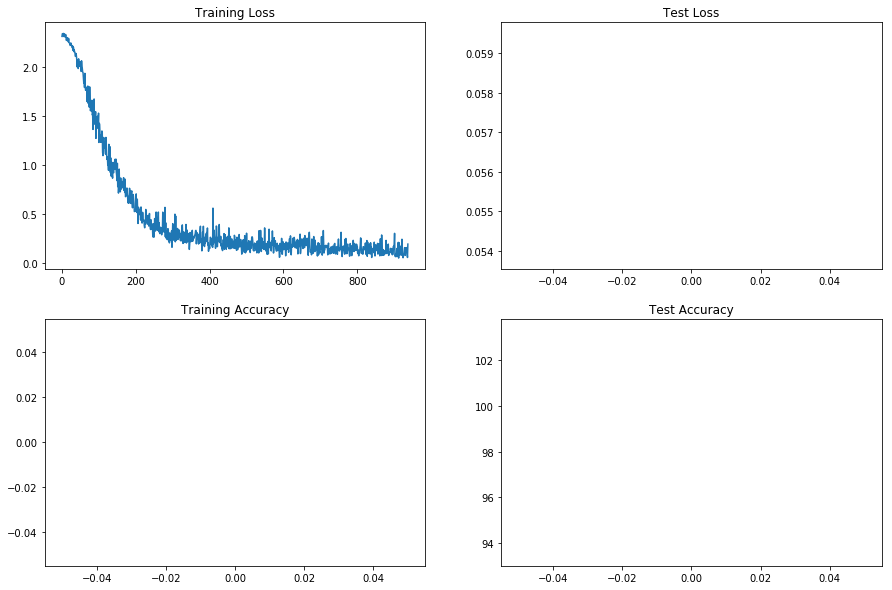

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [16]:
import os

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'MNIST_model_with_L1.h5' 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
torch.save(model12, filepath)

C:\Users\ojhaj\Anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net12. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [28]:
import os
import numpy as np
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_data')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath_test_loss_with_l1 = os.path.join(save_dir, 'test_loss_with_l1.npy')
filepath_test_acc_with_l1 = os.path.join(save_dir, 'test_acc_with_l1.npy')
np.save(filepath_test_loss_with_l1,test_losses)
np.save(filepath_test_acc_with_l1,test_acc)

In [29]:
loaded_test_losses_with_l1 =  np.load(filepath_test_loss_with_l1).tolist()
loaded_test_acc_with_l1 =  np.load(filepath_test_acc_with_l1).tolist()

Text(0.5, 1.0, 'Test Accuracy')

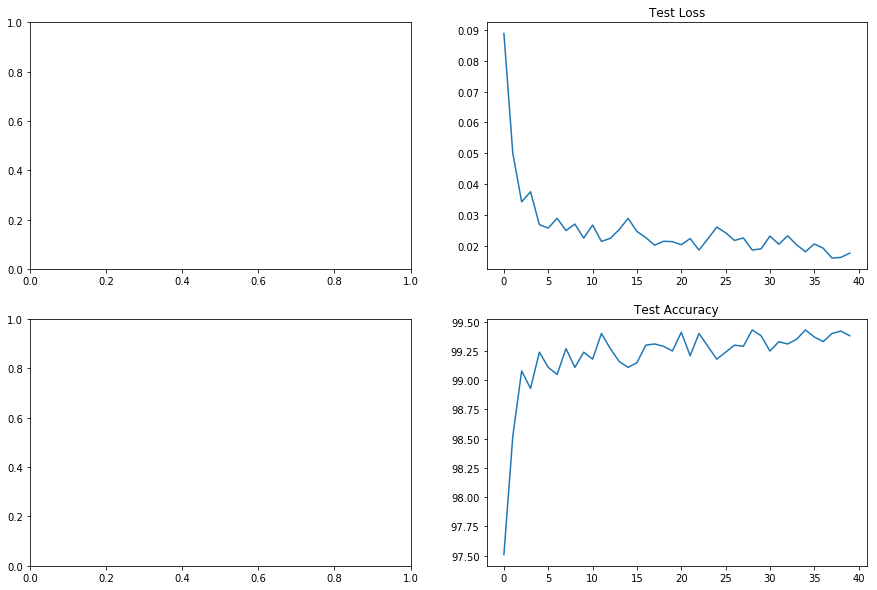

In [30]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 1].plot(loaded_test_losses_with_l1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(loaded_test_acc_with_l1)
axs[1, 1].set_title("Test Accuracy")

In [15]:
the_model = torch.load(filepath)

In [16]:
the_model.to(device)
optimizer = optim.SGD(the_model.parameters(), lr=0.01, momentum=0.9)
test_losses = []
test_acc = []
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    test(the_model, device, test_loader)

EPOCH: 0

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 1

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 2

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 3

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 4

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 5

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 6

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 7

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 8

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 9

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 10

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 11

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 12

Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)

EPOCH: 13

Test set: Average loss: 0.0186, Accur

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
_= axs[0].plot(acc_history)
_= axs[0].plot(val_acc_history)
_= axs[0].set_title('model accuracy')
_= axs[0].set_ylabel('accuracy')
_= axs[0].set_xlabel('epoch')
_= axs[0].legend(['train', 'val'], loc='upper left')
_= axs[1].plot(loss_history)
_= axs[1].plot(val_loss_history)
_= axs[1].set_title('model loss')
_= axs[1].set_ylabel('loss')
_= axs[1].set_xlabel('epoch')
_= axs[1].legend(['train', 'val'], loc='upper left')

In [44]:
def model_pred(model, device, y_test, batchsize=test_mnist.test_data.cpu().numpy().shape[0]):
    from sklearn.metrics import confusion_matrix, classification_report
    model.eval()
    dataldr_args = dict(shuffle=False, batch_size=batchsize, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=10000)
    test_ldr = torch.utils.data.DataLoader(test_mnist, **dataldr_args)
    with torch.no_grad():
        for data, target in test_ldr:
            data, target = data.to(device), target.to(device)
            output = model12(data)
            y_pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        y_pred = y_pred.cpu().numpy()
    print(confusion_matrix(y_test, y_pred.reshape(-1)))
    print('\n')
    print(classification_report(y_test, y_pred.reshape(-1), target_names=class_names))
    return y_pred

In [45]:
def display_mislabelled(model, device, x_test, y_test, y_pred, title_str):
    fig = plt.figure(figsize=(30,9))
    fig.suptitle(title_str, fontsize=24)
    idx1 = np.where(y_test[:] != y_pred)[0]
    for j in range(3):
        for i in range(len(class_names)):
            ax = fig.add_subplot(3, 10, j*10+i+1, xticks=[], yticks=[])
            idx = np.where(y_test[:] == i)[0]
            intsct = np.intersect1d(idx1, idx)
            features_idx = x_test[intsct, ::]
            img_num = np.random.randint(features_idx.shape[0])
            im = features_idx[img_num]
            ax.set_title('Act:{} '.format(i) + ' Pred:{} '.format(y_pred[intsct[img_num]][0]), fontsize=20)
            plt.imshow(im)
    plt.show()

In [46]:
y_test = test_mnist.test_labels.cpu().numpy()
y_pred = model_pred(model12, device, y_test)

[[ 976    1    1    0    0    0    1    1    0    0]
 [   0 1128    3    3    0    0    1    0    0    0]
 [   0    2 1012    5    0    0    3    7    3    0]
 [   0    0    2  998    0    2    0    6    1    1]
 [   1    0    0    0  969    0    2    0    0   10]
 [   1    0    0   11    0  871    6    1    0    2]
 [   2    6    1    0    4    2  943    0    0    0]
 [   0    6    9    0    0    1    0 1011    0    1]
 [   2    1    2    1    6    4    1    2  947    8]
 [   4    2    0    0    6    0    0   11    0  986]]


              precision    recall  f1-score   support

        zero       0.99      1.00      0.99       980
         one       0.98      0.99      0.99      1135
         two       0.98      0.98      0.98      1032
       three       0.98      0.99      0.98      1010
        four       0.98      0.99      0.99       982
        five       0.99      0.98      0.98       892
         six       0.99      0.98      0.98       958
       seven       0.97      0.98 

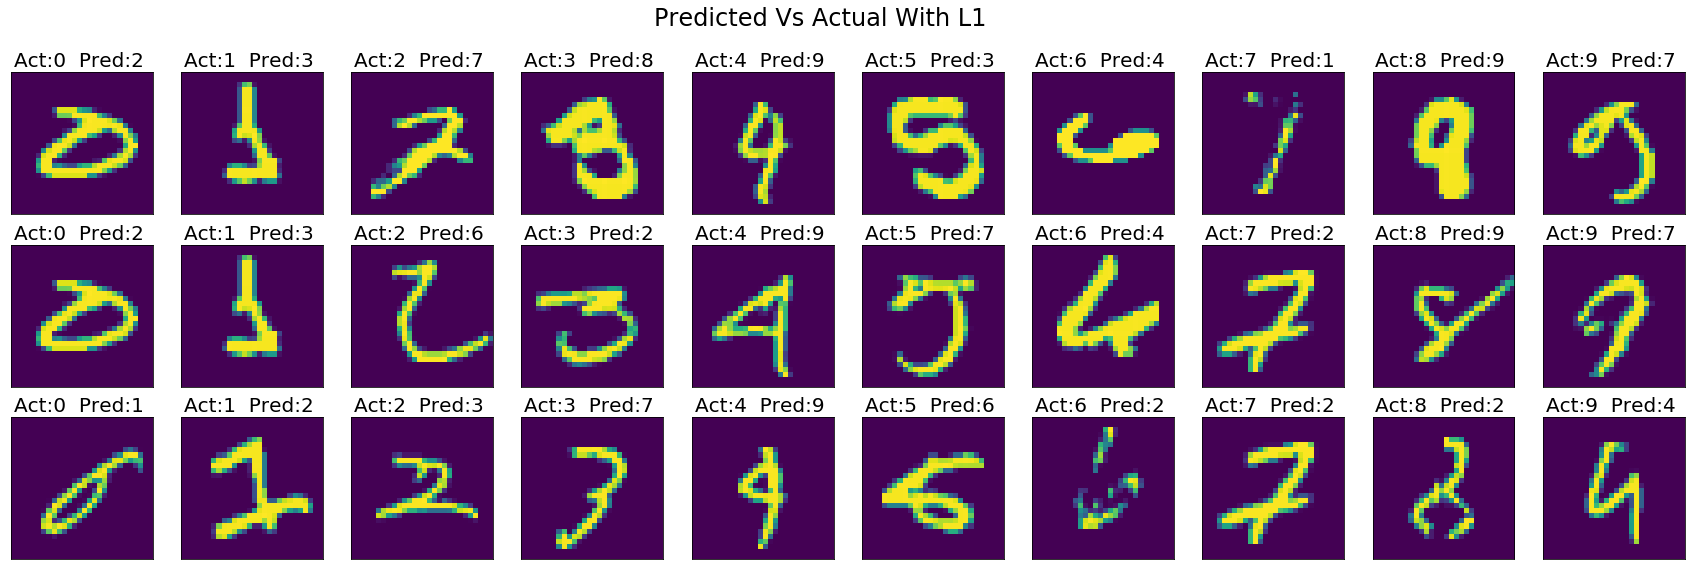

In [47]:
x_test = test_mnist.test_data.cpu().numpy()
display_mislabelled(model12, device,  x_test, y_test.reshape(-1,1), y_pred, title_str='Predicted Vs Actual With L1' )